<a href="https://colab.research.google.com/github/atlantiquesun/GitHub-Data-Driven-Alpha-in-Tech-Industry/blob/main/demo/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
exec(open("/content/drive/MyDrive/StockML /Code/models.py").read())

# 1. Prepare Data

In [13]:
def build_dataset(start_company = 0, end_company = 82, exclude_companies = [],
                     start_month = "9/01/2010", end_month = "4/01/2021",
                     company_path = "/content/drive/MyDrive/StockML /github_data/companyInfo/companies_final.csv", 
                     git_data_path = "/content/drive/MyDrive/StockML /github_data/processedData/monthlyData/",
                     fin_data_path = "/content/drive/MyDrive/StockML /github_data/processedData/financialData/",
                     ):
  
  
  start_month = pd.to_datetime(start_month)
  end_month = pd.to_datetime(end_month)

  companies = pd.read_csv(company_path, sep = ";")
  df_complete = None
  for i in range(start_company, end_company):

    company_git = companies.at[i, 'githubUser']
    if (company_git in exclude_companies):
      continue

    company_name = companies.at[i, "shortName"]
    company_ticker = companies.at[i, "symbol"]
    # print(i, company_git, company_name)
    
    months = pd.date_range(start = start_month, end = end_month + relativedelta(months = 1), freq = 'M')
    months = [x + relativedelta(days = 1) - relativedelta(months = 1) for x in months]
    df = pd.DataFrame(index = months)
    df_git = pd.read_csv(git_data_path + company_git + ".csv", index_col = 0)
    df_fin = pd.read_csv(fin_data_path + company_ticker + ".csv", index_col = 0)

    # select months
    df_git["month_start"] = pd.to_datetime(df_git["month_start"])
    df_fin["month_start"] = pd.to_datetime(df_fin["month_start"])
    df_git["month_end"] = pd.to_datetime(df_git["month_end"])
    df_fin["month_end"] = pd.to_datetime(df_fin["month_end"])
    df_git = df_git.loc[(df_git["month_start"] >= start_month) & (df_git["month_start"] <= end_month)]
    df_fin = df_fin.loc[(df_fin["month_start"] >= start_month) & (df_fin["month_start"] <= end_month)]

    # concatenate GitHub data and stock data
    df_git.index = df_git["month_start"]
    df_fin.index = df_fin["month_start"]
    df = pd.concat([df, df_git, df_fin], axis = 1)
    df.drop(columns=["month_end", "month_start"], inplace=True)
    df.dropna(inplace = True) # drop rows with missing data
    df["month_start"] = df.index
    df["githubUser"] = company_git
    df["ticker"] = company_ticker

    
    # concatenate to df_complete
    if (df_complete is None):
      df_complete = df
    else:
      df_complete = pd.concat([df_complete, df])

  df_complete.reset_index(drop = True, inplace = True)
  return df_complete


def multistep(df, n_steps, feature_columns = ['star', 'fork', 'issue', 'commit', 'issueClosed', 'pullRequestClosed', 'pullRequestMerged', 'pullRequest']
              ):
  
  for i in range(1, n_steps + 1):
    for col in feature_columns:
      df[col + '(t-' + str(i) + ')'] = df[col].shift(i)
  
  df.dropna(inplace=True)
  return df


def prepare_train_data(df, start_month, end_month,
                       n_steps = 4, feature_columns = ['star', 'fork', 'issue', 'commit', 'issueClosed', 'pullRequestClosed', 'pullRequestMerged', 'pullRequest'],
                       target_column = "monthly_return"
                       ):
  
  start_month = pd.to_datetime(start_month)
  start_month -= relativedelta(months = n_steps) # prepare for multistep()
  end_month = pd.to_datetime(end_month)
  df['month_start'] = pd.to_datetime(df['month_start'])

  # select the range of data
  df = df.loc[(df['month_start'] >= start_month) & (df['month_start'] <= end_month)]
  
  # prepare return values
  X_train = pd.DataFrame(columns = feature_columns)
  y_train = pd.DataFrame(columns = [target_column])
  df_scaler = pd.DataFrame(columns = ['scaler', 'githubUser'])

  companies = df['githubUser'].unique()
  for cpn in companies:
    df_temp = df[df['githubUser'] == cpn]
    y_temp = df_temp[[target_column]]
    X_temp = df_temp[feature_columns]

    # normalize
    scaler = MinMaxScaler()
    X_temp = pd.DataFrame(data = scaler.fit_transform(X_temp), columns = feature_columns)
    df_scaler.append({"scaler": scaler, "githubUser": cpn}, ignore_index = True)

    # multistep()
    X_temp = multistep(X_temp, n_steps, feature_columns)
    y_temp = y_temp.iloc[n_steps:] # drop the first n_steps rows

    # concatenate to training data
    X_train = pd.concat([X_train, X_temp], axis = 0)
    y_train = pd.concat([y_train, y_temp], axis = 0)
  
  df_scaler.index = df_scaler.githubUser
  return (X_train.values, y_train.values.ravel(), df_scaler)


def prepare_val_data(df, start_month, end_month, df_scaler,
                       n_steps = 4, feature_columns = ['star', 'fork', 'issue', 'commit', 'issueClosed', 'pullRequestClosed', 'pullRequestMerged', 'pullRequest'],
                       target_column = "monthly_return"
                       ):
  
   start_month = pd.to_datetime(start_month)
   start_month -= relativedelta(months = n_steps) # prepare for multistep()
   end_month = pd.to_datetime(end_month)
   df['month_start'] = pd.to_datetime(df['month_start'])

   # select the range of data
   df = df.loc[(df['month_start'] >= start_month) & (df['month_start'] <= end_month)]
  
   # prepare return values
   X_val = pd.DataFrame(columns = feature_columns)
   y_val = pd.DataFrame(columns = [target_column])
   trade_tic = []

   companies = df['githubUser'].unique()
   for cpn in companies:
     df_temp = df.loc[df['githubUser'] == cpn]
     y_temp = df_temp[[target_column]]
     X_temp = df_temp[feature_columns]

     # normalize
     if(cpn in df_scaler['githubUser'].unique()): # if this company is seen in the training data, use the scaler for training data
       scaler = df_scaler.at[cpn, 'scaler']
     else: # if not seen, fit a new scaler
        scaler = MinMaxScaler()
        scaler.fit(X_temp)
     X_temp = pd.DataFrame(data = scaler.transform(X_temp), columns = feature_columns)

     # multistep()
     X_temp = multistep(X_temp, n_steps, feature_columns)
     if(X_temp.shape[0] == 0): # not enough data
       continue
     y_temp = y_temp.iloc[n_steps:] # drop the first n_steps rows
     trade_tic.append(df.loc[(df['month_start'] == end_month) & (df["githubUser"] == cpn)]['ticker'].values[0])

     # concatenate to the validation data
     X_val = pd.concat([X_val, X_temp], axis = 0)
     y_val = pd.concat([y_val, y_temp], axis = 0)
  
   return (X_val.values, y_val.values.ravel(), trade_tic)


# auxiliary functions

def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import mean_squared_log_error

    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score
    y_predict = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    explained_variance = explained_variance_score(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)

    return mse


def append_return_table(df_predict, unique_datetime, y_trade_return, trade_tic, current_index):
    tmp_table = pd.DataFrame(columns=trade_tic)
    tmp_table = tmp_table.append(pd.Series(y_trade_return, index=trade_tic), ignore_index=True)
    df_predict.loc[unique_datetime[current_index]][tmp_table.columns] = tmp_table.loc[0]


def sanity_check():
  '''
  sanity check to see if append_return_table fills in y_trade values correctly for each ticker
  '''
  df_test = pd.DataFrame(np.zeros((3, 5)), columns = ['a', 'b', 'c', 'd', 'e'])
  tics = ['b', 'e', 'a'] # the order changes
  t = pd.DataFrame(columns = tics)
  t = t.append(pd.Series(np.asarray([1., 2., 3.]), index=tics), ignore_index=True)
  display(t)
  df_test.loc[1][tics] = t.loc[0]
  display(df_test)

**Test**

In [15]:
df = build_dataset(start_company = 0, end_company = 82, exclude_companies = ["microsoft", "facebook", "google", "westerndigitalcorporation", "xilinx"])
display(df)

,star,fork,issue,commit,issueClosed,pullRequestClosed,pullRequestMerged,pullRequest,open,high,low,close,adj close,volume,monthly_return,month_start,githubUser,ticker
0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,321.359985,323.429993,318.510010,322.440002,322.440002,2636200.0,-0.048962,2014-09-01,amzn,AMZN
1,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,305.149994,305.720001,301.500000,305.459991,305.459991,4550700.0,-0.052661,2014-10-01,amzn,AMZN
2,5.0,0.0,1.0,99.0,0.0,0.0,0.0,0.0,336.029999,341.260010,336.029999,338.640015,338.640015,3051800.0,0.108623,2014-11-01,amzn,AMZN
3,3.0,1.0,1.0,87.0,0.0,0.0,0.0,1.0,311.549988,312.980011,310.010010,310.350006,310.350006,2048000.0,-0.083540,2014-12-01,amzn,AMZN
4,9.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,346.320007,359.500000,340.739990,354.529999,354.529999,23856100.0,0.142355,2015-01-01,amzn,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,679.0,117.0,26.0,659.0,19.0,186.0,127.0,210.0,323.500000,323.500000,312.470001,314.660004,314.660004,587100.0,0.079933,2020-12-01,spotify,SPOT
3149,1208.0,136.0,54.0,771.0,26.0,243.0,174.0,230.0,328.589996,331.390015,312.829987,315.000000,315.000000,1485500.0,0.001081,2021-01-01,spotify,SPOT
3150,605.0,106.0,49.0,854.0,31.0,298.0,209.0,317.0,300.000000,311.829987,295.339996,307.380005,307.380005,2595700.0,-0.024190,2021-02-01,spotify,SPOT
3151,643.0,141.0,64.0,998.0,35.0,385.0,253.0,428.0,266.279999,271.869995,263.899994,267.950012,267.950012,1194500.0,-0.128278,2021-03-01,spotify,SPOT


# 2. Train

In [ ]:

'''
Training Parameters
'''
train_start_month = pd.to_datetime("11/01/2013")
n_windows = 60
train_window = 24 # 24 months 
val_window = 6
n_steps = 6
git_feature_columns = ['star', 'fork', 'issue', 'commit', 'issueClosed', 'pullRequestClosed', 'pullRequestMerged', 'pullRequest']
stock_feature_columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
feature_columns = git_feature_columns # currently only using GitHub-related features



'''
Training 
'''
train_start_months = [train_start_month + relativedelta(months = x) for x in range(n_windows)]
val_start_months = [x + relativedelta(months = train_window) for x in train_start_months]
trade_months = [x + relativedelta(months = val_window) for x in val_start_months]
print("Last trade month:", trade_months[-1])
unique_ticker = set(df['ticker'])
unique_datetime = trade_months

df_predict_lr = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lasso = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ridge = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_rf = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_svm= pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_gbm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ada = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lstm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)

df_predict_best = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_best_model_name = pd.DataFrame(columns=['model_name'], index=unique_datetime)
evaluation_record = []


for i in range(len(unique_datetime)):
  train_start_month = train_start_months[i]
  val_start_month = val_start_months[i]
  trade_month = unique_datetime[i]

  X_train, y_train, df_scaler = prepare_train_data(df, train_start_month, train_start_month + relativedelta(months=train_window), 
                                                   n_steps, feature_columns)
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], -1, len(feature_columns))) # (samples, timesteps, features)
  print(X_train_lstm.shape, y_train.shape)

  X_val, y_val, _ = prepare_val_data(df, val_start_month, val_start_month + relativedelta(months=val_window), df_scaler, n_steps, feature_columns)
  X_val_lstm = np.reshape(X_val, (X_val.shape[0], -1, len(feature_columns),))

  X_trade, y_trade, trade_tic = prepare_val_data(df, trade_month, trade_month, df_scaler, n_steps, feature_columns)
  X_trade_lstm = np.reshape(X_trade, (X_trade.shape[0], -1, len(feature_columns)))

   # train the models
  lr_model = train_linear_regression(X_train, y_train)
  print("*****LR done")
  lasso_model = train_lasso(X_train, y_train)
  print("*****LASSO done")
  ridge_model = train_ridge(X_train, y_train)
  print("*****RIDGE done")
  rf_model = train_random_forest(X_train, y_train)
  print("*****RF done")
  svm_model = train_svm(X_train,y_train)
  print("*****SVM done")
  gbm_model = train_gbm(X_train, y_train)
  print("*****GBM done")
  ada_model = train_ada(X_train, y_train)
  print("*****ADA done")
  lstm_model = train_lstm(X_train_lstm, y_train)
  print("*****LSTM done")

  # validation 
  lr_eval = evaluate_model(lr_model, X_val, y_val)
  lasso_eval = evaluate_model(lasso_model, X_val, y_val)
  ridge_eval = evaluate_model(ridge_model, X_val, y_val)
  rf_eval = evaluate_model(rf_model, X_val, y_val) 
  svm_eval = evaluate_model(svm_model, X_val, y_val)
  gbm_eval = evaluate_model(gbm_model, X_val, y_val)
  ada_eval = evaluate_model(ada_model, X_val, y_val)
  lstm_eval = evaluate_model(lstm_model, X_val_lstm, y_val)

        
  # trade
  y_trade_lr = lr_model.predict(X_trade).flatten()
  y_trade_lasso = lasso_model.predict(X_trade).flatten()
  y_trade_ridge = ridge_model.predict(X_trade).flatten()
  y_trade_rf = rf_model.predict(X_trade).flatten()
  y_trade_svm = svm_model.predict(X_trade).flatten()
  y_trade_gbm = gbm_model.predict(X_trade).flatten()
  y_trade_ada = ada_model.predict(X_trade).flatten()
  y_trade_lstm = lstm_model.predict(X_trade_lstm).flatten()

  # prepare evaluation data and predicted return
  eval_data = [[lr_eval, y_trade_lr], 
                    [lasso_eval, y_trade_lasso],
                     [ridge_eval, y_trade_ridge],
                     [rf_eval, y_trade_rf], 
                     [svm_eval,y_trade_svm],
                     [gbm_eval,y_trade_gbm],                     
                     [ada_eval,y_trade_ada],
                    [lstm_eval,y_trade_lstm]
                    ]

  eval_table = pd.DataFrame(eval_data, columns=['model_eval', 'model_predict_return'],
                                  index=['lr', 
                                         'lasso',
                                         'ridge',
                                         'rf', 
                                         'svm',
                                         'gbm',
                                         'ada', 
                                         'lstm'])  
  evaluation_record.append((trade_month, eval_table))

  # lowest error score model
  y_trade_best = eval_table.model_predict_return.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  best_model_name = eval_table.index.values[eval_table.model_eval == eval_table.model_eval.min()][0]

  df_best_model_name.loc[trade_month] = best_model_name

  # Prepare Predicted Return table
  append_return_table(df_predict_lr, unique_datetime, y_trade_lr, trade_tic, current_index=i)
  append_return_table(df_predict_lasso, unique_datetime, y_trade_lasso, trade_tic, current_index=i)
  append_return_table(df_predict_ridge, unique_datetime, y_trade_ridge, trade_tic, current_index=i)
  append_return_table(df_predict_rf, unique_datetime, y_trade_rf, trade_tic, current_index=i)
  append_return_table(df_predict_svm, unique_datetime, y_trade_svm, trade_tic, current_index=i)
  append_return_table(df_predict_gbm, unique_datetime, y_trade_gbm, trade_tic, current_index=i)
  append_return_table(df_predict_ada, unique_datetime, y_trade_ada, trade_tic, current_index=i)
  append_return_table(df_predict_lstm, unique_datetime, y_trade_lstm, trade_tic, current_index=i)
  append_return_table(df_predict_best, unique_datetime, y_trade_best, trade_tic, current_index=i)

  print("Trade month:", trade_month)


df_predict_lr.to_csv(result_path + "lr.csv")
df_predict_lasso.to_csv(result_path + "lasso.csv")
df_predict_ridge.to_csv(result_path + "ridge.csv")
df_predict_rf.to_csv(result_path + "rf.csv")
df_predict_svm.to_csv(result_path + "svm.csv")
df_predict_gbm.to_csv(result_path + "gbm.csv")
df_predict_ada.to_csv(result_path + "ada.csv")
df_predict_lstm.to_csv(result_path + "lstm.csv")
df_predict_best.to_csv(result_path + "best.csv")

# 3. Visualization

In [25]:
# calculate monthly return

def _long_only_strategy_monthly(df_predict_return, tic_monthly_return, trade_month, top_quantile_threshold=0.75):
    long_dict = {}
    for i in range(df_predict_return.shape[0]):
        top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
        # low_q=df_predict_return.iloc[i].quantile(0.2)
        # Select all stocks
        # long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][~np.isnan(df_predict_return.iloc[i])]
        # Select Top 30% Stocks
        long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]
        # short_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i]<=low_q]

    portfolio_return_dic = {}
    for i in range(len(trade_month)):
        # for longX_train_rf only
        # calculate weight based on predicted return
        long_normalize_weight = long_dict[trade_month[i]] / sum(long_dict[trade_month[i]].values)
        # map date and tic
        long_tic_return = tic_monthly_return[tic_monthly_return.index == trade_month[i]][
            long_dict[trade_month[i]].index]
        # return * weight
        long_return_table = long_tic_return * long_normalize_weight
        portfolio_return_dic[trade_month[i]] = long_return_table.values.sum()

        # for short only
        # short_normalize_weight=short_dict[trade_month[i]]/sum(short_dict[trade_month[i]].values)
        # short_tic_return=tic_monthly_return[tic_monthly_return.index==trade_month[i]][short_dict[trade_month[i]].index]
        # short_return_table=short_tic_return
        # portfolio_return_dic[trade_month[i]] = long_return_table.values.sum() + short_return_table.values.sum()

    df_portfolio_return = pd.DataFrame.from_dict(portfolio_return_dic, orient='index')
    df_portfolio_return = df_portfolio_return.reset_index()
    df_portfolio_return.columns = ['trade_month', 'monthly_return']
    df_portfolio_return.index = df_portfolio_return.trade_month
    df_portfolio_return = df_portfolio_return['monthly_return']
    return df_portfolio_return

def get_monthly_return(trade_months, unique_ticker,
                       company_path = "/content/drive/MyDrive/StockML /github_data/processedData/financialData/"):
  '''
  returns:
    monthly_return: pd.DataFrame
      index = trade_months, columns = unique_ticker, may contain NaN 
  '''
  # get the monthly return of each stocks
  monthly_return = pd.DataFrame(index=trade_months)
  monthly_return.index.name = "month_start"
  monthly_return.index = pd.to_datetime(monthly_return.index)
  for company in unique_ticker:
    df_temp = pd.read_csv(company_path + company +'.csv')
    df_temp['month_start'] = pd.to_datetime(df_temp['month_start'])
    df_temp = df_temp.loc[(df_temp['month_start'] >= trade_months[0]) & (df_temp['month_start'] <= trade_months[-1])]
    df_company = pd.DataFrame(df_temp['monthly_return'].values, index = df_temp['month_start'], columns=[company])
    monthly_return = pd.concat([monthly_return, df_company], axis = 1)
  
  return monthly_return

In [26]:
top_quantile_threshold = 0.75
df_monthly_return = get_monthly_return(trade_months, unique_ticker)

# load results
result_path = "/content/drive/MyDrive/StockML /github_data/results/results_2/"
df_predict_lr = pd.read_csv(result_path + "lr.csv", index_col = 0)
df_predict_lasso = pd.read_csv(result_path + "lasso.csv", index_col = 0)
df_predict_ridge = pd.read_csv(result_path + "ridge.csv", index_col = 0)
df_predict_rf = pd.read_csv(result_path + "rf.csv", index_col = 0)
df_predict_svm = pd.read_csv(result_path + "svm.csv", index_col = 0)
df_predict_gbm = pd.read_csv(result_path + "gbm.csv", index_col = 0)
df_predict_ada = pd.read_csv(result_path + "ada.csv", index_col = 0)
df_predict_lstm = pd.read_csv(result_path + "lstm.csv", index_col = 0)
df_predict_best = pd.read_csv(result_path + "best.csv", index_col = 0)

# convert indices to datetime objects
df_predict_lr.index = pd.to_datetime(df_predict_lr.index)
df_predict_lasso.index = pd.to_datetime(df_predict_lasso.index)
df_predict_ridge.index = pd.to_datetime(df_predict_ridge.index)
df_predict_rf.index = pd.to_datetime(df_predict_rf.index)
df_predict_svm.index = pd.to_datetime(df_predict_svm.index)
df_predict_gbm.index = pd.to_datetime(df_predict_gbm.index)
df_predict_ada.index = pd.to_datetime(df_predict_ada.index)
df_predict_lstm.index = pd.to_datetime(df_predict_lstm.index)
df_predict_best.index = pd.to_datetime(df_predict_best.index)

# calculate portfolio return
df_portfolio_return_lr = _long_only_strategy_monthly(df_predict_lr, df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_lasso = _long_only_strategy_monthly(df_predict_lasso, df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_ridge = _long_only_strategy_monthly(df_predict_ridge, df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_rf    = _long_only_strategy_monthly(df_predict_rf,   df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_svm   = _long_only_strategy_monthly(df_predict_svm,  df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_gbm    = _long_only_strategy_monthly(df_predict_gbm,   df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_ada   = _long_only_strategy_monthly(df_predict_ada,  df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_lstm  = _long_only_strategy_monthly(df_predict_lstm, df_monthly_return, trade_months, top_quantile_threshold)
df_portfolio_return_best  = _long_only_strategy_monthly(df_predict_best, df_monthly_return,trade_months, top_quantile_threshold)

# calculate baseline (equal portfolio return)
selected_monthly_return = df_monthly_return[unique_ticker]
equally_portfolio_return=[]
for i in range(len(trade_months)):
    return_remove_nan = selected_monthly_return.iloc[i][~np.isnan(df_monthly_return.iloc[i])] 
    equally_portfolio_return.append(sum(return_remove_nan)/len(return_remove_nan))

df_equally_portfolio_return=pd.DataFrame(equally_portfolio_return, index = trade_months, columns = ['monthly_return'])

# 3. Visualization

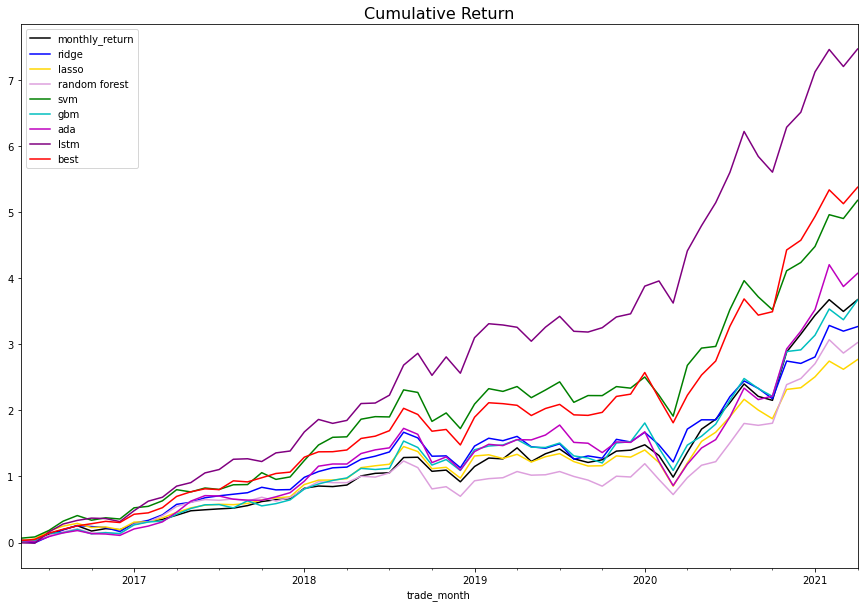

In [27]:
# plot the figure
fig, ax = plt.subplots(figsize=(15,10))
baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(ax=ax, c='black',label='baseline')
ridge = ((df_portfolio_return_ridge+1).cumprod()-1).plot(ax=ax, c='b',label='ridge')
lasso = ((df_portfolio_return_lasso+1).cumprod()-1).plot(ax=ax, c='gold',label='lasso')
rf = ((df_portfolio_return_rf+1).cumprod()-1).plot(ax=ax, c='plum',label='random forest')
svm = ((df_portfolio_return_svm+1).cumprod()-1).plot(ax=ax, c='green',label='svm')
gbm = ((df_portfolio_return_gbm+1).cumprod()-1).plot(ax=ax, c='c',label='gbm')
ada = ((df_portfolio_return_ada+1).cumprod()-1).plot(ax=ax, c='m',label='ada')
lstm = ((df_portfolio_return_lstm+1).cumprod()-1).plot(ax=ax, c='purple',label='lstm')
best = ((df_portfolio_return_best+1).cumprod()-1).plot(ax=ax, c='r',label='best')
plt.legend()
plt.title('Cumulative Return', {'size':16})
plt.show()